In [1]:
from brian2 import *

prefs.codegen.target = "numpy"

## Минимальный набор
\# переделать латех выражения как систему
$$ \alpha_n = 0.032 \frac{15 - v + v_T}{\exp(\frac{15 - v + v_T}{5}) - 1} $$

$$ \beta_n = 0.5 \exp(\frac{10 - v + v_T}{40}) $$

$$ \alpha_m = 0.32 \frac{13 - v + v_T}{\exp(\frac{13 - v + v_T}{4}) - 1} $$

$$ \beta_m = 0.28 \frac{v - v_T - 40}{\exp(\frac{v - v_T - 40}{5}) - 1} $$


$$ \alpha_h = 0.128 \exp(\frac{17 - v + v_T}{18}) $$

$$ \beta_h = \frac{4}{1 + \exp(\frac{40 - v + v_T}{5})} $$

In [2]:
Cm = 20 * pF
Ena = 55 * mV
Ek = -85 * mV
El = -70 * mV
gK = 40 * nS
gL = 5 * nS
gNa = 50 * nS

VT = -63 * mV  # from brain examples

eqs = """
dv/dt = (gL * (El - v) + gK * n**4 * (Ek - v) + gNa*m**3*h*(Ena - v) + I) / Cm : volt

dn/dt = a_n * (1 - n) - b_n * n : 1
a_n = 0.032/mV * 5*mV / exprel((15*mV - v + VT)/5/mV) / ms : Hz
b_n = 0.5 * exp((10*mV - v + VT)/40/mV) / ms : Hz

dm/dt = a_m * (1 - m) - b_m * m : 1
a_m = 0.32/mV * 4*mV / exprel((13*mV - v + VT)/4/mV) / ms : Hz
b_m = 0.28/mV * 5*mV / exprel((v - VT - 40*mV)/5/mV) / ms : Hz
dh/dt = a_h * (1 - h) - b_h * h : 1
a_h = 0.128*exp((17*mV - v + VT)/18/mV) / ms : Hz
b_h = 4 / (1 + exp((40*mV - v + VT)/5/mV)) / ms : Hz


I : ampere
"""

neuron = NeuronGroup(1, eqs, method='euler')

stmon = StateMonitor(neuron, ['v'], True)

neuron.v = El

currs = [75, 90, 100, 125, 150, 200]

for i in currs:
    neuron.I = i * pA
    run(180*ms)
    neuron.I = 0 * pA
    run(20*ms)

run(70*ms)

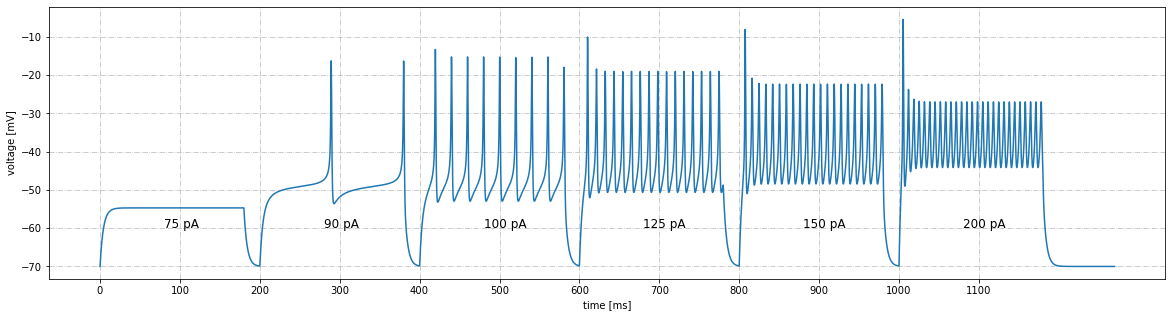

In [10]:
figure(figsize=(20, 5))
plot(stmon.t/ms, stmon.v[0]/mV)
ylabel("voltage [mV]")
xlabel("time [ms]")
xticks(ticks=range(0, 1200, 100))
grid(alpha=.8, ls='-.')
for i, cur in enumerate(currs):
    text(200*i+80, -60, f"{cur} pA", fontsize=12)
#savefig("basic_spikes.jpeg", dpi=200)

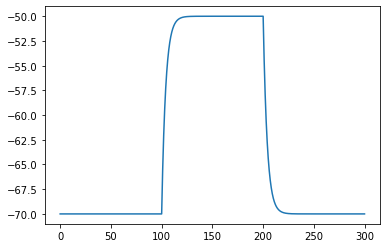

In [22]:
# only leaky
eqs = """
dv/dt = (gL * (El - v) + I) / Cm : volt

I : ampere
"""

neuron = NeuronGroup(1, eqs, method='euler')

stmon = StateMonitor(neuron, ['v'], True)

neuron.v = El

run(100*ms)
neuron.I = 0.1 * nA
run(100*ms)
neuron.I = 0 * nA
run(100*ms)

plot(stmon.t/ms, stmon.v[0]/mV)

# Синапсы

## Просто синапс (один к одному)

In [20]:
Cm = 20 * pF
Ena = 55 * mV
Ek = -85 * mV
El = -70 * mV
gK = 40 * nS
gL = 5 * nS
gNa = 50 * nS

VT = -63 * mV  # from brain examples

syn_w = 0.5 * pA
tau_s = 7.5 * ms

eqs = """
dv/dt = (gL * (El - v) + gK * n**4 * (Ek - v) + gNa*m**3*h*(Ena - v) + I + Isyn) / Cm : volt

dn/dt = a_n * (1 - n) - b_n * n : 1
a_n = 0.032/mV * 5*mV / exprel((15*mV - v + VT)/5/mV) / ms : Hz
b_n = 0.5 * exp((10*mV - v + VT)/40/mV) / ms : Hz

dm/dt = a_m * (1 - m) - b_m * m : 1
a_m = 0.32/mV * 4*mV / exprel((13*mV - v + VT)/4/mV) / ms : Hz
b_m = 0.28/mV * 5*mV / exprel((v - VT - 40*mV)/5/mV) / ms : Hz
dh/dt = a_h * (1 - h) - b_h * h : 1
a_h = 0.128*exp((17*mV - v + VT)/18/mV) / ms : Hz
b_h = 4 / (1 + exp((40*mV - v + VT)/5/mV)) / ms : Hz

dIsyn/dt = -Isyn/tau_s : ampere

I : ampere
"""

neuron = NeuronGroup(2, eqs, method='euler', threshold='v > -40*mV', reset='')
stmon = StateMonitor(neuron, ['v'], True)
neuron.v = El

syns = Synapses(neuron, neuron, on_pre='Isyn += syn_w')
syns.connect(i=0, j=1)

currs = [90, 100, 125, 150, 200]

for i in currs:
    neuron.I[0] = i * pA
    run(180*ms)
    neuron.I[0] = 0 * pA
    run(20*ms)

run(70*ms)

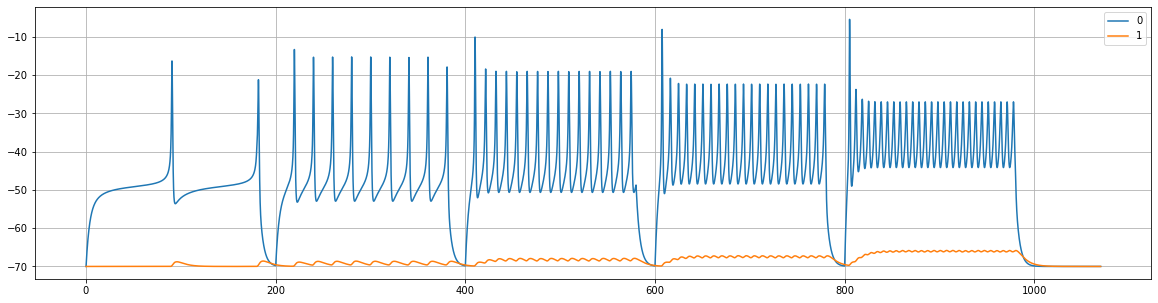

In [22]:
figure(figsize=(20, 5))
plot(stmon.t/ms, stmon.v[0]/mV, label='0')
plot(stmon.t/ms, stmon.v[1]/mV, label='1')
grid()
legend()

## Несколько нейронов к одному

In [38]:
Cm = 20 * pF
Ena = 55 * mV
Ek = -85 * mV
El = -70 * mV
gK = 40 * nS
gL = 5 * nS
gNa = 50 * nS

VT = -63 * mV  # from brain examples

syn_w = 0.5 * pA
tau_s = 7.5 * ms

eqs = """
dv/dt = (gL * (El - v) + gK * n**4 * (Ek - v) + gNa*m**3*h*(Ena - v) + I + Isyn) / Cm : volt

dn/dt = a_n * (1 - n) - b_n * n : 1
a_n = 0.032/mV * 5*mV / exprel((15*mV - v + VT)/5/mV) / ms : Hz
b_n = 0.5 * exp((10*mV - v + VT)/40/mV) / ms : Hz

dm/dt = a_m * (1 - m) - b_m * m : 1
a_m = 0.32/mV * 4*mV / exprel((13*mV - v + VT)/4/mV) / ms : Hz
b_m = 0.28/mV * 5*mV / exprel((v - VT - 40*mV)/5/mV) / ms : Hz
dh/dt = a_h * (1 - h) - b_h * h : 1
a_h = 0.128*exp((17*mV - v + VT)/18/mV) / ms : Hz
b_h = 4 / (1 + exp((40*mV - v + VT)/5/mV)) / ms : Hz

dIsyn/dt = -Isyn/tau_s : ampere

I : ampere
"""

neuron = NeuronGroup(11, eqs, method='euler', threshold='v > -40*mV', reset='')
stmon = StateMonitor(neuron, ['v'], True)
neuron.v = El

syns = Synapses(neuron, neuron, on_pre='Isyn += syn_w')
syns.connect(i=range(0, 10), j=10)

currs = [90, 100, 125, 150, 200]

for i in currs:
    neuron.I[0:11] = i * pA
    run(180*ms)
    neuron.I[0:11] = 0 * pA
    run(20*ms)

run(70*ms)

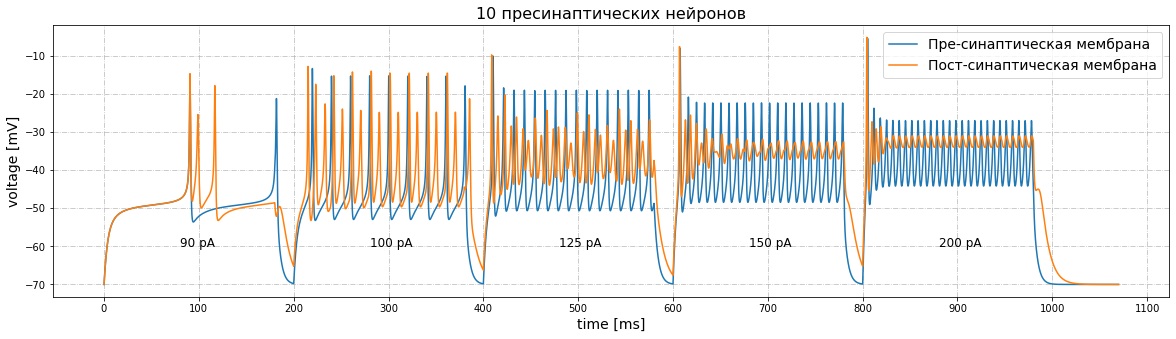

In [39]:
figure(figsize=(20, 5))
title("10 пресинаптических нейронов", fontsize=16)
plot(stmon.t/ms, stmon.v[0]/mV, label='Пре-синаптическая мембрана')
plot(stmon.t/ms, stmon.v[10]/mV, label='Пост-синаптическая мембрана')
grid()
legend(fontsize=14)
ylabel("voltage [mV]", fontsize=14)
xlabel("time [ms]", fontsize=14)
xticks(ticks=range(0, 1200, 100))
grid(alpha=.8, ls='-.')
for i, cur in enumerate(currs):
    text(200*i+80, -60, f"{cur} pA", fontsize=12)
#savefig("десять_к_одному.jpeg", dpi=200)

## Один к одному, много нейротрансмиттера

In [40]:
Cm = 20 * pF
Ena = 55 * mV
Ek = -85 * mV
El = -70 * mV
gK = 40 * nS
gL = 5 * nS
gNa = 50 * nS

VT = -63 * mV  # from brain examples

syn_w = 10 * pA
tau_s = 7.5 * ms

eqs = """
dv/dt = (gL * (El - v) + gK * n**4 * (Ek - v) + gNa*m**3*h*(Ena - v) + I + Isyn) / Cm : volt

dn/dt = a_n * (1 - n) - b_n * n : 1
a_n = 0.032/mV * 5*mV / exprel((15*mV - v + VT)/5/mV) / ms : Hz
b_n = 0.5 * exp((10*mV - v + VT)/40/mV) / ms : Hz

dm/dt = a_m * (1 - m) - b_m * m : 1
a_m = 0.32/mV * 4*mV / exprel((13*mV - v + VT)/4/mV) / ms : Hz
b_m = 0.28/mV * 5*mV / exprel((v - VT - 40*mV)/5/mV) / ms : Hz
dh/dt = a_h * (1 - h) - b_h * h : 1
a_h = 0.128*exp((17*mV - v + VT)/18/mV) / ms : Hz
b_h = 4 / (1 + exp((40*mV - v + VT)/5/mV)) / ms : Hz

dIsyn/dt = -Isyn/tau_s : ampere

I : ampere
"""

neuron = NeuronGroup(2, eqs, method='euler', threshold='v > -40*mV', reset='')
stmon = StateMonitor(neuron, ['v'], True)
neuron.v = El

syns = Synapses(neuron, neuron, on_pre='Isyn += syn_w')
syns.connect(i=0, j=1)

currs = [90, 100, 125, 150, 200]

for i in currs:
    neuron.I[0:11] = i * pA
    run(180*ms)
    neuron.I[0:11] = 0 * pA
    run(20*ms)

run(70*ms)

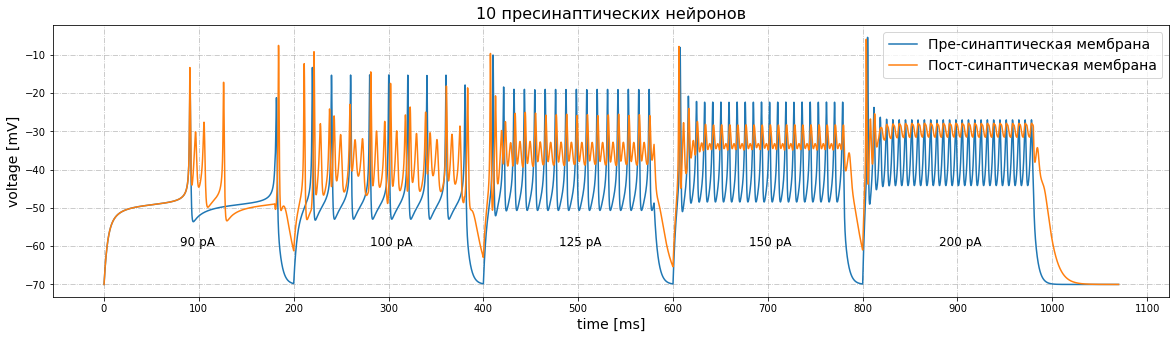

In [41]:
figure(figsize=(20, 5))
title("10 пресинаптических нейронов", fontsize=16)
plot(stmon.t/ms, stmon.v[0]/mV, label='Пре-синаптическая мембрана')
plot(stmon.t/ms, stmon.v[1]/mV, label='Пост-синаптическая мембрана')
grid()
legend(fontsize=14)
ylabel("voltage [mV]", fontsize=14)
xlabel("time [ms]", fontsize=14)
xticks(ticks=range(0, 1200, 100))
grid(alpha=.8, ls='-.')
for i, cur in enumerate(currs):
    text(200*i+80, -60, f"{cur} pA", fontsize=12)
#savefig("один_к_одному.jpeg", dpi=200)

## Подпороговая активность

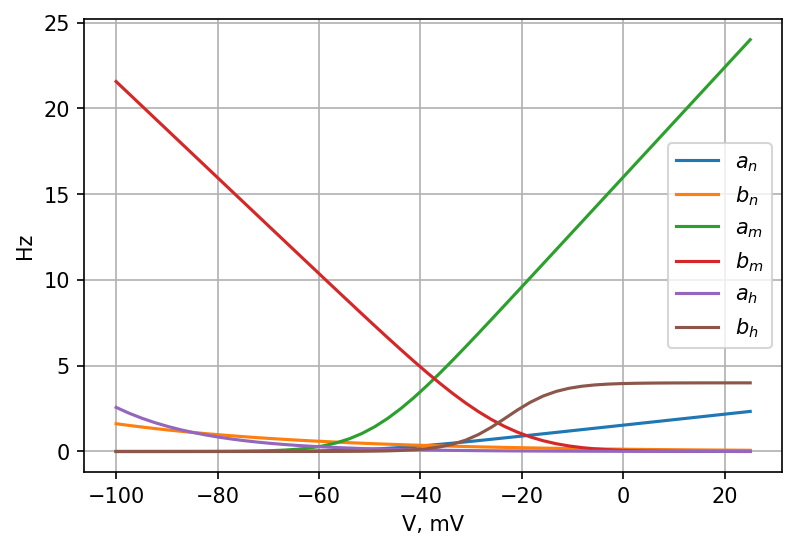

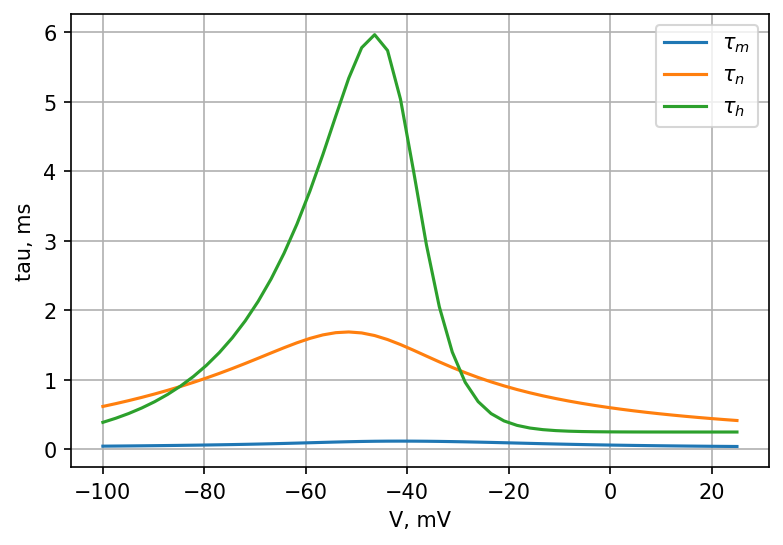

In [56]:
vv = np.linspace(-100, 25)
VT_ = -63
an = 0.032 * 5 / exprel((15 - vv + VT_)/5)
bn = 0.5 * exp((10 - vv + VT_)/40)
n_inf = an / (an + bn)
tau_n = 1 / (an + bn)

am = 0.32 * 4 / exprel((13 - vv + VT_)/4)
bm = 0.28 * 5 / exprel((vv - VT_ - 40)/5)
m_inf = am / (am + bm)
tau_m = 1 / (am + bm)

ah = 0.128*exp((17 - vv + VT_)/18)
bh = 4 / (1 + exp((40 - vv + VT_)/5))
h_inf = ah / (ah + bh)
tau_h = 1 / (ah + bh)

figure(figsize=(6,4), dpi=150)
plot(vv, an, label='$a_n$')
plot(vv, bn, label='$b_n$')
plot(vv, am, label='$a_m$')
plot(vv, bm, label='$b_m$')
plot(vv, ah, label='$a_h$')
plot(vv, bh, label='$b_h$')
grid()
ylabel('Hz')
xlabel('V, mV')
legend()

figure(figsize=(6, 4), dpi=150)
plot(vv, tau_m)
plot(vv, tau_n)
plot(vv, tau_h)
grid()
ylabel('tau, ms')
xlabel('V, mV')
legend([f"$\\tau_{x}$" for x in ['m', 'n', 'h']])

In [40]:
start_scope()
Cm = 20*pF

eqs = """
dv/dt = (gL * (El - v) + gK * n**4 * (Ek - v) + gNa*m**3*h*(Ena - v) + I + Isyn) / Cm : volt

dn/dt = a_n * (1 - n) - b_n * n : 1
a_n = 0.032/mV * 5*mV / exprel((15*mV - v + VT)/5/mV) / ms : Hz
b_n = 0.5 * exp((10*mV - v + VT)/40/mV) / ms : Hz

dm/dt = a_m * (1 - m) - b_m * m : 1
a_m = 0.32/mV * 4*mV / exprel((13*mV - v + VT)/4/mV) / ms : Hz
b_m = 0.28/mV * 5*mV / exprel((v - VT - 40*mV)/5/mV) / ms : Hz
dh/dt = a_h * (1 - h) - b_h * h : 1
a_h = 0.128*exp((17*mV - v + VT)/18/mV) / ms : Hz
b_h = 4 / (1 + exp((40*mV - v + VT)/5/mV)) / ms : Hz

dIsyn/dt = -Isyn/tau_s : ampere

I : ampere
"""

test = NeuronGroup(1, eqs, method='euler')
testmon = StateMonitor(test, ['v', 'n', 'm', 'h'], True)

test.v = El
test.I = 100*pA

run(30*ms)
test.I = 0 * pA
run(50*ms)

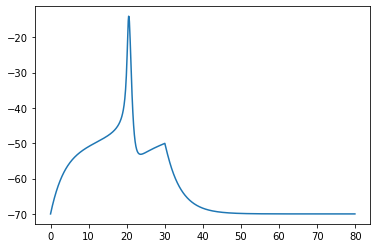

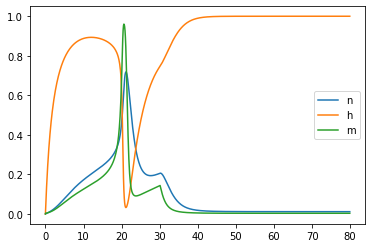

In [41]:
plot(testmon.t/ms, testmon.v[0]/mV)
figure()
plot(testmon.t/ms, testmon.n[0], label='n')
plot(testmon.t/ms, testmon.h[0], label='h')
plot(testmon.t/ms, testmon.m[0], label='m')
legend()